# Exploratory Data Analysis - Crime Data Los Angeles

This notebook is used to explore the questions for the Data Scientist Exercise in July 2020.

- How else has reported crime changed over time in the City?
- Based on your analysis, please share any changes to services, programs, or policies that the City should consider.

##  Load libraries

In [49]:
# Import libraries
import os, sys, subprocess
import json
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)
%config InlineBackend.figure_format = 'retina'
plt.style.use('fivethirtyeight')

In [2]:
# load project config
terminal_call = ! git rev-parse --show-toplevel
repo_path=terminal_call[0]
project_config_path = os.path.join(repo_path,'project_config.json')

with open(project_config_path,'r') as fp: 
    project_config = json.load(fp)

In [5]:
# import custom module to look at trends
module_path = os.path.join(repo_path,project_config['project_module_relative_path'])
sys.path.append(module_path)

import trends
from trends import get_top_trends as gt
from trends import convert
from trends.convert import crime_dict, mocode_dict, violent_crime_dict, desc_dict # load in crime name dictionary
from importlib import reload # for updating scripts

# Load in data

In [6]:
# load in data that was collected
df = pickle.load(open("../data/crime_data.pkl", "rb"))

In [7]:
# Explore summary info
def eda(df):
    nulls = pd.DataFrame(df.isnull().sum()).T # Check for nulls
    datatypes = pd.DataFrame(df.dtypes).T # Check datatypes
    summary = pd.concat([nulls, datatypes], keys = ["nulls", "datatypes"]) # Create pandas dataframe, because I think it's easier to read
    return summary

In [8]:
eda(df)

,,dr_no,date_rptd,date_occ,time_occ,area,area_name,rpt_dist_no,part_1-2,crm_cd,crm_cd_desc,mocodes,vict_age,vict_sex,vict_descent,premis_cd,premis_desc,weapon_used_cd,weapon_desc,status,status_desc,crm_cd_1,crm_cd_2,crm_cd_3,crm_cd_4,location,cross_street,lat,lon,year,mocodes_1,mocodes_2,mocodes_3
nulls,0,0,0,0,0,0,0,0,0,0,0,240361,0,208478,208527,55,228,1464999,1465000,3,0,11,2063105,2206364,2209991,0,1837686,0,0,0,0,0,0
datatypes,0,int64,datetime64[ns],datetime64[ns],int64,int64,object,int64,int64,int64,object,object,int64,object,object,float64,object,float64,object,object,object,float64,float64,float64,float64,object,object,float64,float64,int64,int64,int64,int64


## How else has reported crime changed over time in the City?

In [9]:
total_crimes = pd.DataFrame(df.groupby("year").size().reset_index(name ="total_cases"))

In [10]:
total_crimes.set_index("year", inplace = True)
total_crimes.head()

,total_cases
year,
2010,200536
2011,197858
2012,200110
2013,192146
2014,194966


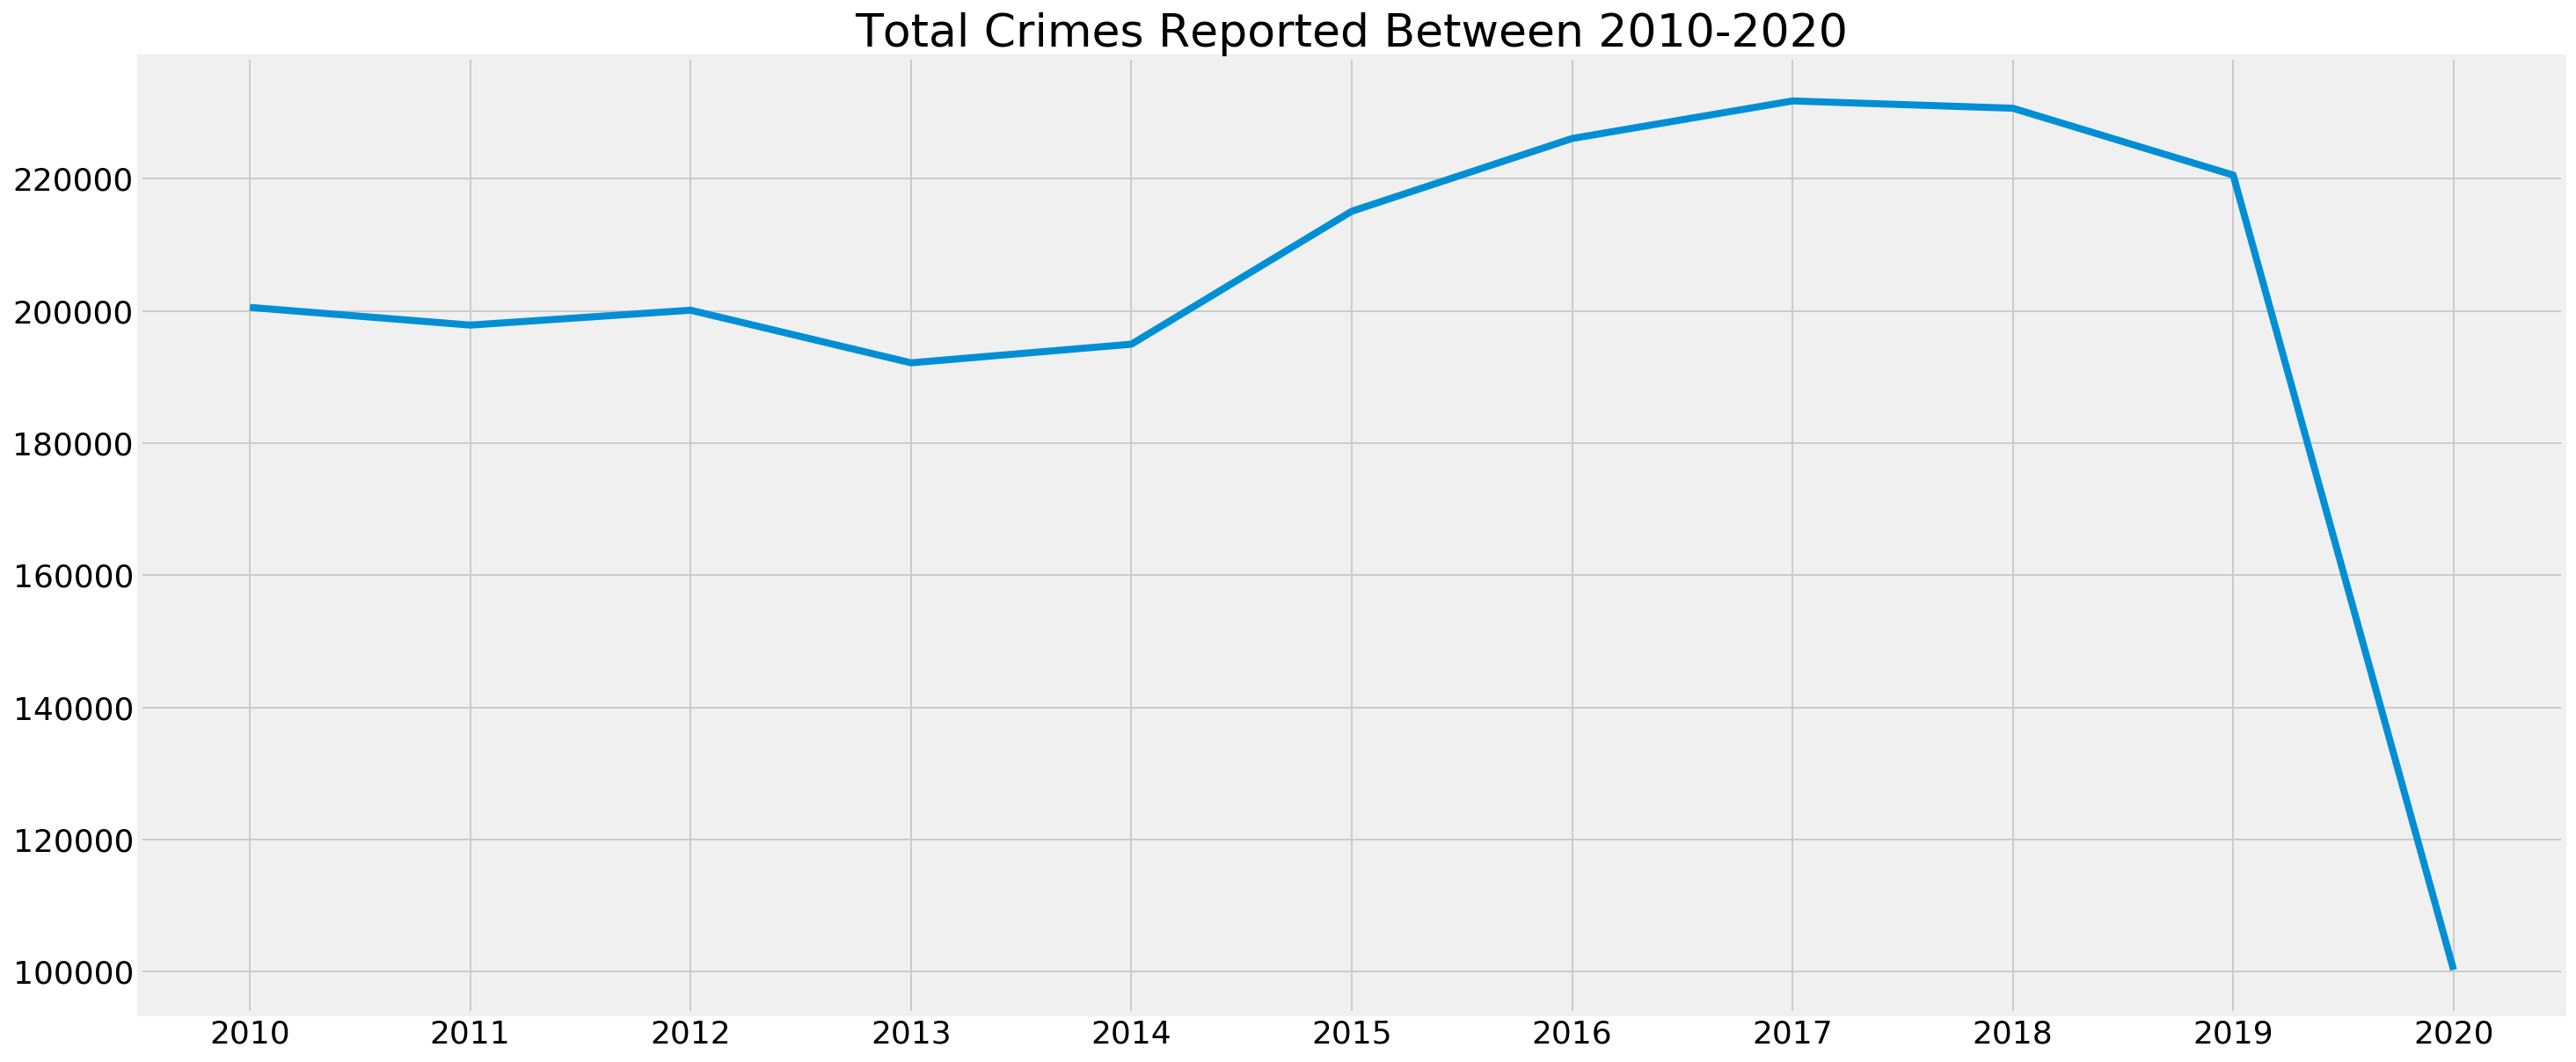

In [11]:
# Generate a time plot of our data.
gt.plot_series(total_crimes,
            ['total_cases'],
            title = 'Total Crimes Reported Between 2010-2020',
            steps = 1);

## Calculate rolling means for daily crimes reported

In [12]:
# calculate rolling means for the number of crimes reported each day

#group by date
crimes = pd.DataFrame(df.groupby("date_rptd").size().reset_index(name ="total_cases"))
crimes.set_index("date_rptd", inplace = True)

In [13]:
# rolling mean for 1 month
crimes["rolling_mean_month"] = crimes["total_cases"].rolling(30).mean()

# quarterly rolling mean
crimes["rolling_mean_quarter"] = crimes["total_cases"].rolling(120).mean()

# annual rolling mean
crimes["rolling_mean_annual"] = crimes["total_cases"].rolling(365).mean()

/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


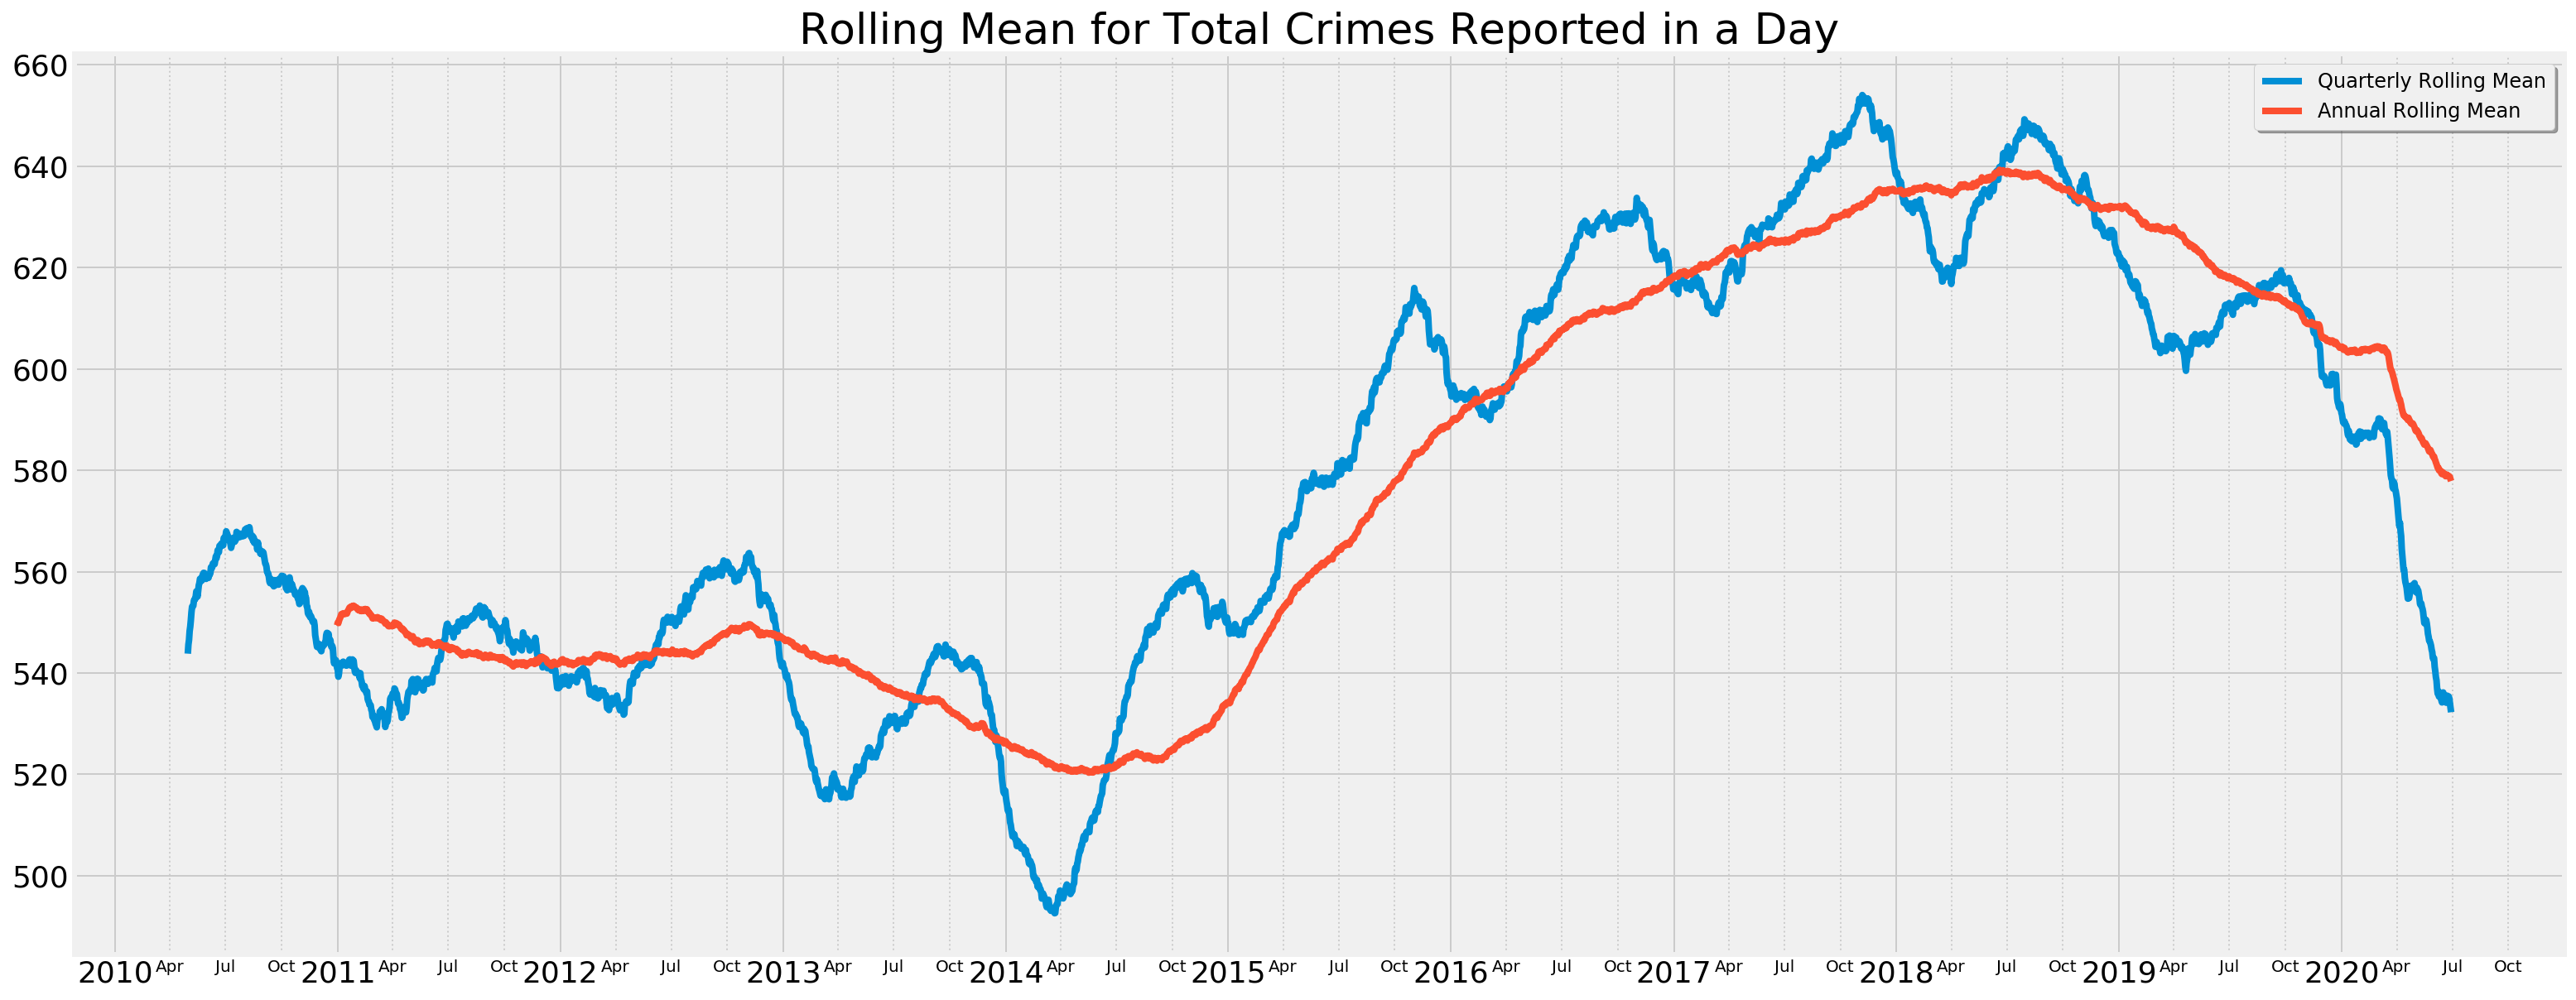

In [14]:
gt.plot_rolling_series(crimes, ["rolling_mean_quarter", "rolling_mean_annual"], 
                    title='Rolling Mean for Total Crimes Reported in a Day')

plt.legend(labels = ["Quarterly Rolling Mean", "Annual Rolling Mean"], loc='upper right',
          fancybox=True, shadow=True, fontsize = 12);

# plt.savefig('../plots/daily_reports_rolling_means.eps', format='eps', dpi=72)

## Are the crimes getting more serious over the years?

According to the datasource, lower crime class numbers are more serious [source](https://data.lacity.org/A-Safe-City/Crime-Data-from-2020-to-Present/2nrs-mtv8). 
Looking at the UCR Crime codes [here](https://data.lacity.org/api/views/63jg-8b9z/files/fff2caac-94b0-4ae5-9ca5-d235b19e3c44?download=true&filename=UCR-COMPSTAT062618.pdf), I created a dictionary of all the violent crime codes.

In [15]:
# create a column that checks if the crime is violent
df["is_violent"]= [i in violent_crime_dict.keys() for i in df["crm_cd"]]

In [16]:
# calculate the % of violent crimes each year and area
violent_crimes = (df.groupby(["year", "area", "area_name"])["is_violent"].sum()/df.groupby(["year", "area"]).size()).reset_index(name="percent_violent")

In [17]:
# only select for year 2010 and 2020
violent_crimes = violent_crimes[(violent_crimes["year"]== 2010) | (violent_crimes["year"]== 2020)]

In [18]:
# conditional color. Color red if the % violent crime increased over the 10 years
highlight = ['#ff3700' if (violent_crimes[violent_crimes["area"] == i]["percent_violent"].values[1] > violent_crimes[violent_crimes["area"] == i]["percent_violent"].values[0]) else "#323232" for i in violent_crimes["area"]]

In [19]:
violent_crimes.head()

,year,area,area_name,percent_violent
0,2010,1,Central,0.391248
1,2010,2,Rampart,0.418766
2,2010,3,Southwest,0.362579
3,2010,4,Hollenbeck,0.348423
4,2010,5,Harbor,0.275000


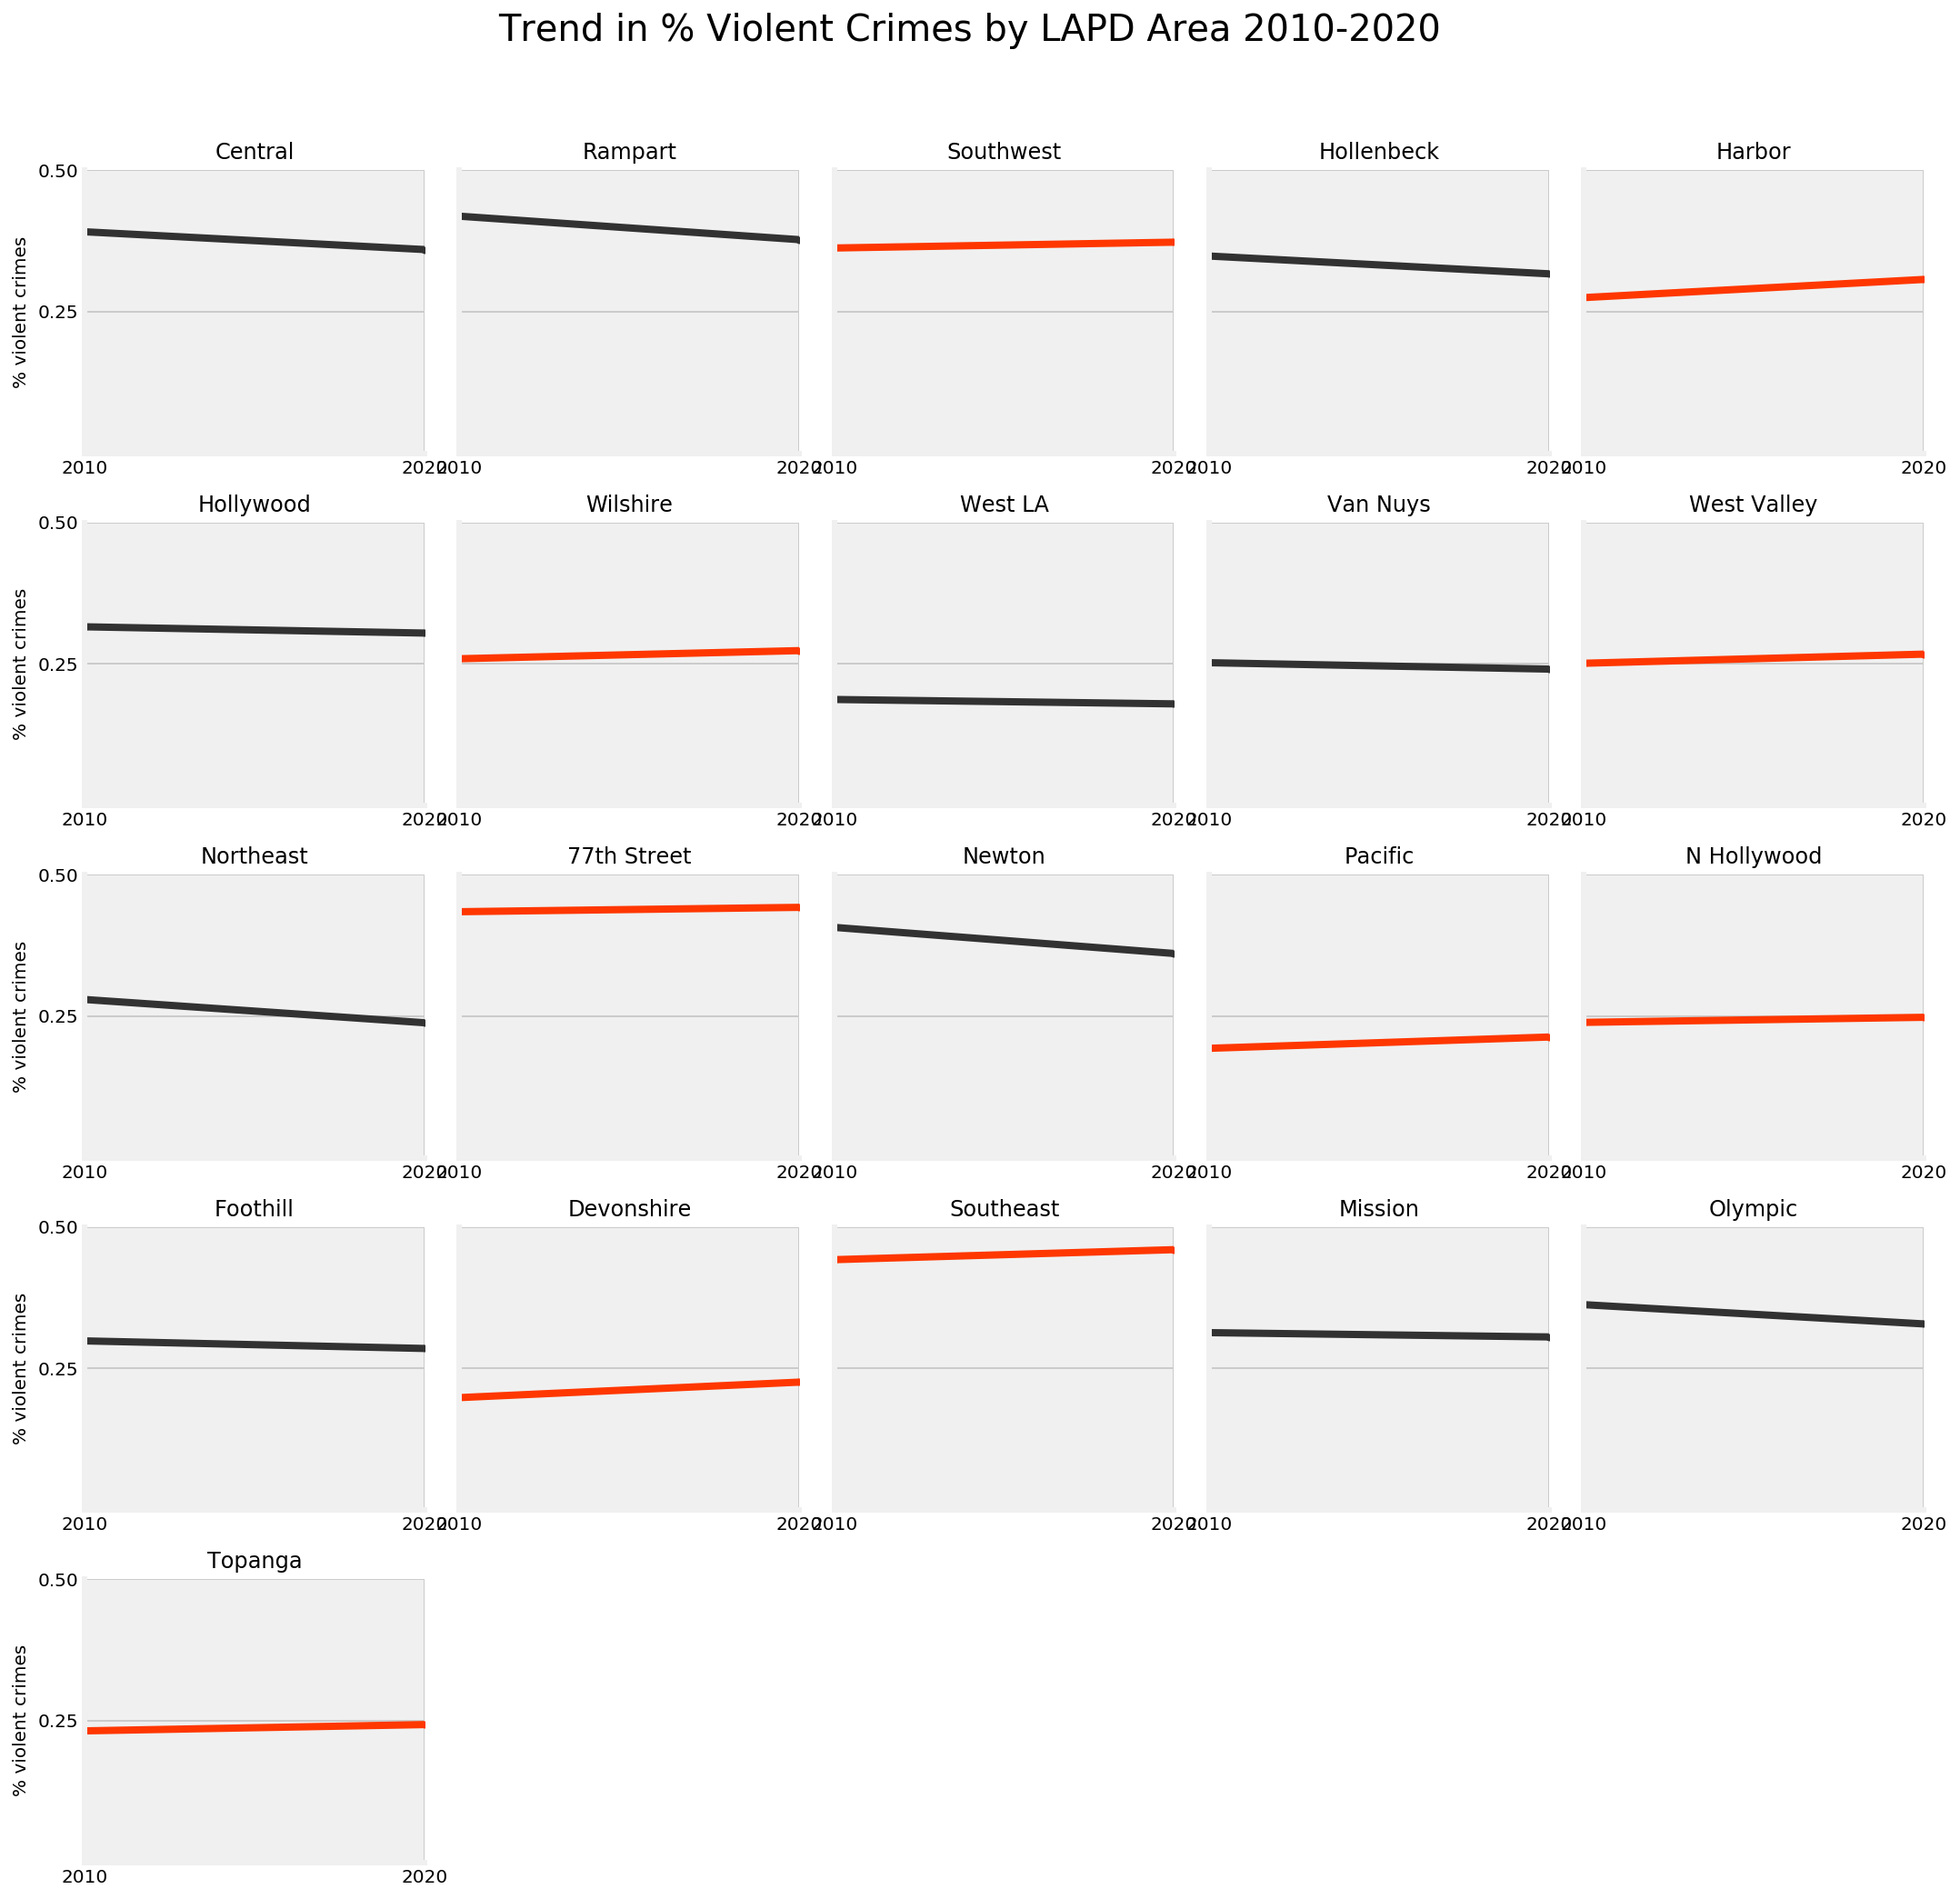

In [20]:
# Plot the trend of % violent crimes over the years, facet by area

g = sns.FacetGrid(violent_crimes, col="area_name", col_wrap=5, height=3, sharex=False)
g = (g.map(plt.plot, "year", "percent_violent", marker=".")).set(ylim=(0,.5), yticks=[.25,.5], xlim=(2010, 2020), xticks=[2010, 2020])
#g.set_xlabels([2010,2020], fontsize=10)
g.set_ylabels("% violent crimes", fontsize=10)
g.set_xlabels("")
g.set_titles("{col_name}")
#g.set_yticklabels(labels=[.25,.5], size=10)
#g.set_xticklabels(labels = [2010,"", "", "", "", 2020], size=10);


# customize color on conditional. If the % of violent crimes has increased over the years, color red. 
for i in np.arange(0,21):
    (g.facet_axis(0,i)).get_lines()[0].set_color(highlight[i])
    

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Trend in % Violent Crimes by LAPD Area 2010-2020', fontsize=20)

plt.savefig('../plots/violent_crimes_area.eps', format='eps', dpi=72)

## What's the status of these crimes

In [21]:
# Checking to see what the status is of all these crimes
df["status_desc"].value_counts()

Invest Cont     1704054
Adult Other     258117 
Adult Arrest    226255 
Juv Arrest      16237  
Juv Other       5406   
UNK             35     
Name: status_desc, dtype: int64

In [22]:
# Checking to see how many reported crimes are still open per year
df[df["status"]=="IC"].groupby("year")["status"].value_counts()

year  status
2010  IC        166788
2011  IC        157188
2012  IC        150634
2013  IC        144317
2014  IC        144640
2015  IC        160863
2016  IC        171019
2017  IC        176370
2018  IC        176626
2019  IC        171131
2020  IC        84478 
Name: status, dtype: int64

In [23]:
# What's the % of cases that are still open?
open = df[df["status"] == "IC"].shape[0]/ df.shape[0]
print("{:.1%}".format(open) + " cases are still open.")

77.1% cases are still open.


In [24]:
# What's the % of cases that led to a juvenile arrest?
ja_cases = df[df["status"] == "JA"].shape[0]/ df[df["status"] != "IC"].shape[0]
print("{:.1%}".format(ja_cases) + " of all closed cases led to a juvenile arrest.")

3.2% of all closed cases led to a juvenile arrest.


## Explore cases that led to a juvenile arrest

In [25]:
# segment dataframe for only the juvenile cases
ja = df[df["status"] == "JA"]

In [26]:
# top crimes that led to a juvenile arrest
ja["crm_cd_desc"].value_counts(ascending = False).head(10)

BATTERY - SIMPLE ASSAULT                                   3101
ROBBERY                                                    2109
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT             1363
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)    999 
BURGLARY                                                   950 
CRIMINAL THREATS - NO WEAPON DISPLAYED                     781 
THEFT PLAIN - PETTY ($950 & UNDER)                         669 
SHOPLIFTING - PETTY THEFT ($950 & UNDER)                   650 
VEHICLE - STOLEN                                           550 
VANDALISM - MISDEAMEANOR ($399 OR UNDER)                   438 
Name: crm_cd_desc, dtype: int64

In [27]:
total_ja = pd.DataFrame(ja.groupby("year").size().reset_index(name ="total_cases"))
total_ja.set_index("year", inplace = True)

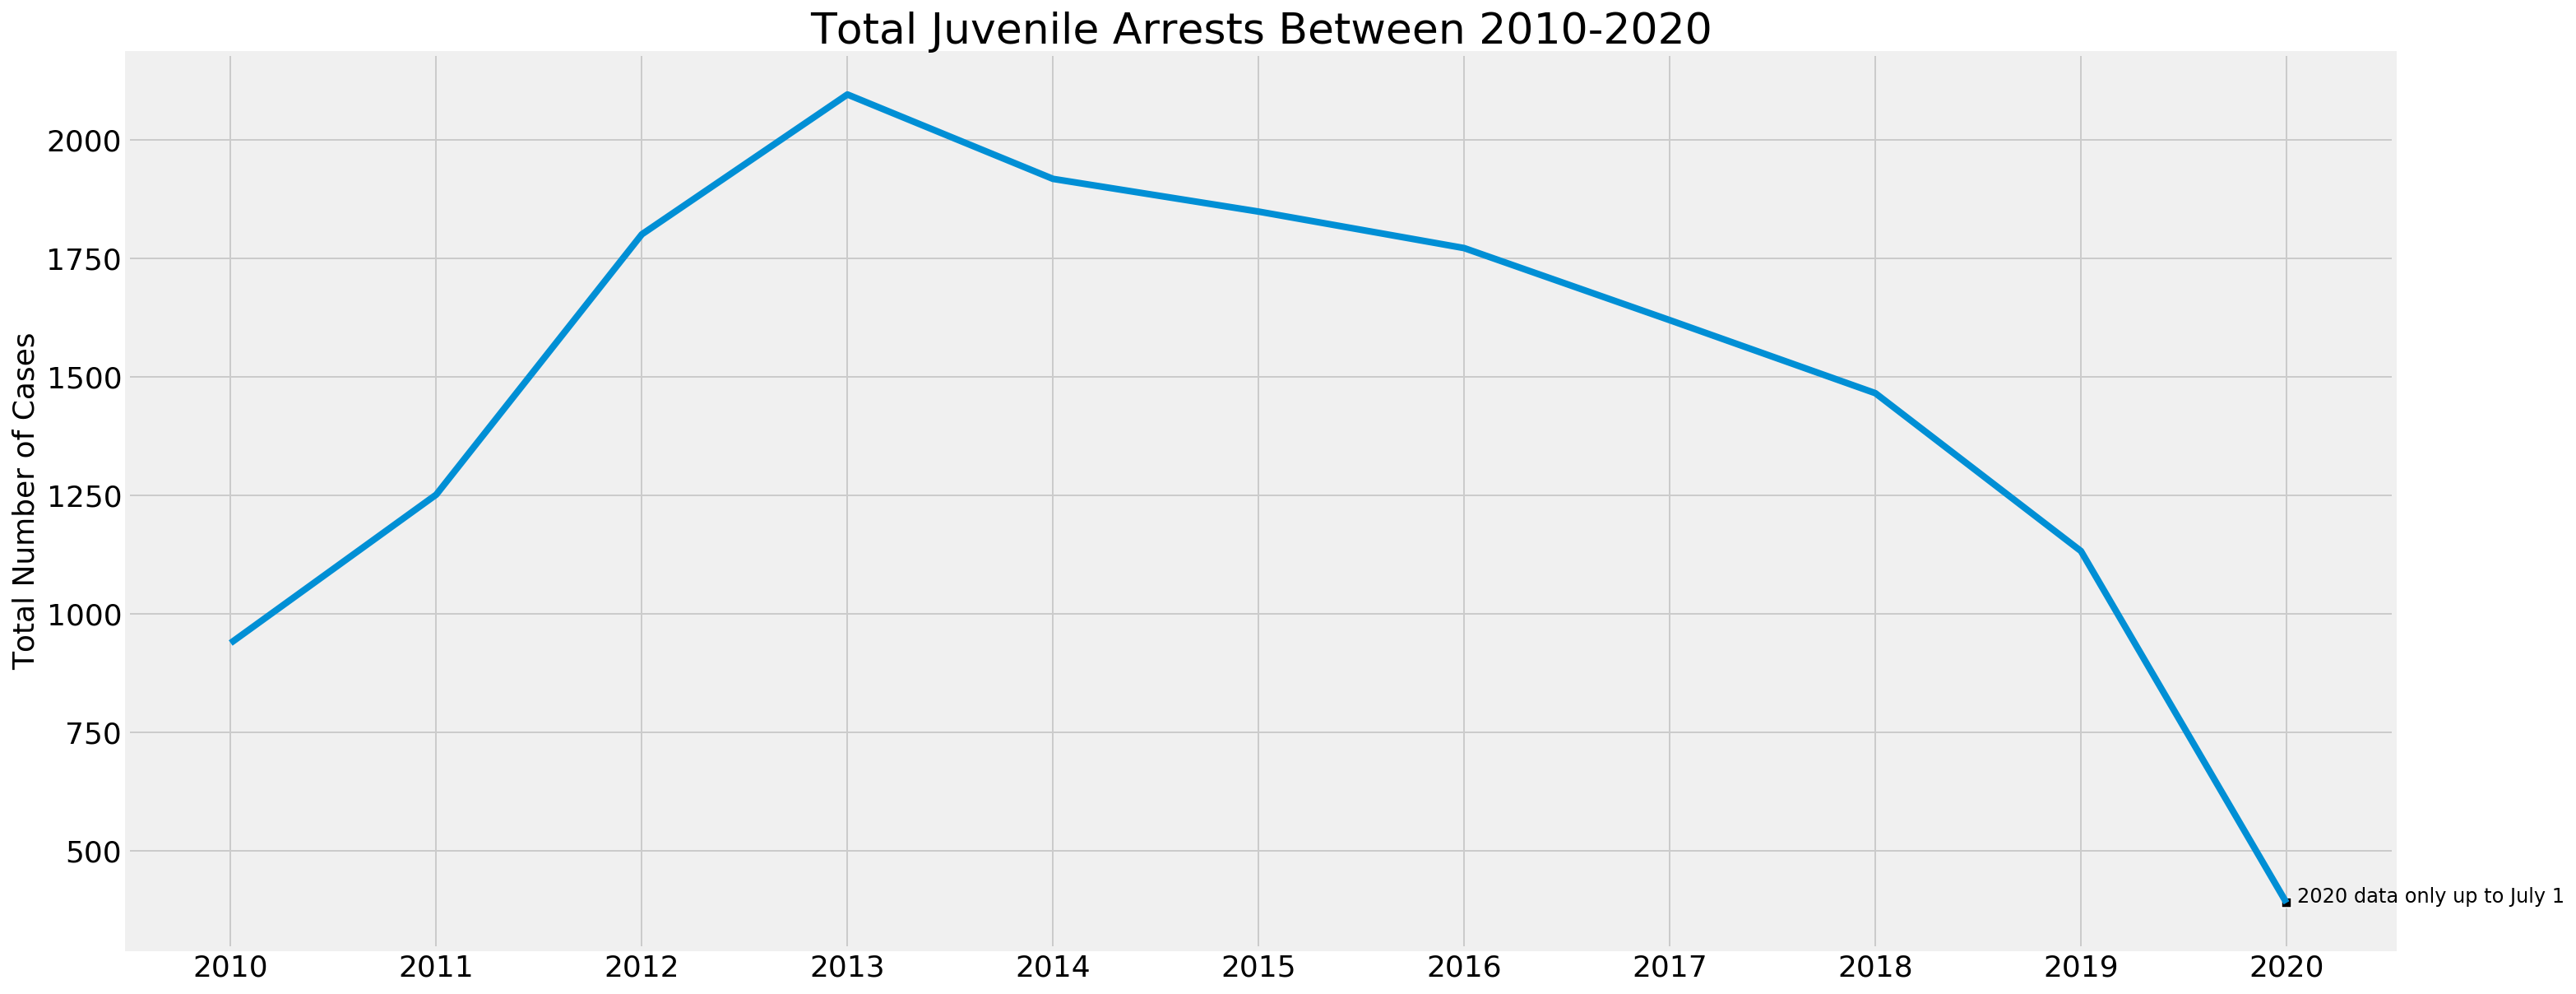

In [28]:
# Generate a time plot of our data.

gt.plot_series(total_ja,
            ['total_cases'],
            title = 'Total Juvenile Arrests Between 2010-2020',
            steps = 1);


ax = sns.scatterplot(x=2020, y="total_cases", data=total_ja.tail(1), legend=False,
                     color = "#000000",marker = "s" )

ax.set(ylabel="Total Number of Cases")

ax.text(2020+0.05, total_ja[total_ja.index==2020]["total_cases"],
             "2020 data only up to July 1", horizontalalignment='left', size =12);

# plt.savefig('../plots/juvenile_arrests.eps', format='eps', dpi=72)

### Overall, the number of juvenile arrests have been decreasing in the past decade. At a quick glance, this shows the possibility that the diversion policies are making a difference.

## Explore cases on domestic violence

Domestic Violence has consistently been one of the top MO's over the last 5 years. Let's explore which populations are most affected. From the MO codes listed [here](https://data.lacity.org/api/views/63jg-8b9z/files/3db69cd3-446c-4dcd-82eb-3436dc08d3be?download=true&filename=MO_CODES_Numerical_20180627.pdf), domestic violence is listed as 2000.

In [29]:
# Filter dataframe for MO domestic violence
dv = df[df["mocodes_1"]==2000]

In [30]:
# Add in the description of the descent codes
dv["vict_desc"] = convert.get_names(dv, "vict_descent", desc_dict)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [36]:
# Add in the description of the MO code 2
dv["mocodes_2_desc"] = convert.get_names(dv, "mocodes_2", mocode_dict)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [37]:
dv["mocodes_2_desc"].value_counts().head(10)

Susp is/was current/former boyfriend/girlfriend    16531
Hit-Hit w/ weapon                                  14996
Susp is/was current/former spouse/co-habitant      12003
Force used                                         7862 
Pushed                                             4541 
Co-habitants                                       4535 
Victim knew Suspect                                3493 
Spouse                                             2373 
Grabbed                                            2130 
Choked/uses choke hold                             1560 
Name: mocodes_2_desc, dtype: int64

In [39]:
dv["vict_age"].value_counts().head(10)

25    3739
24    3709
26    3670
27    3643
23    3490
29    3486
28    3447
22    3300
30    3282
21    3030
Name: vict_age, dtype: int64

In [90]:
# Calculate the timespan between date incident occured and reported
# My hypothesis is that there's a lag between occurance and report
dv["timespan"]=dv["date_rptd"]-dv["date_occ"]
dv["timespan"]= dv["timespan"].dt.days

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [105]:
# What's the average time span (in days) between when an incidence of domestic violence happens and when it's reported for each victim ethnicity?
dv.groupby("vict_desc")["timespan"].mean()

vict_desc
American Indian/Alaskan Native    4.000000 
Asian India                       0.000000 
Black                             4.211847 
Chinese                           14.363636
Filipino                          34.385714
Guamanian                         1.250000 
Hawaiian                          1.000000 
Hispanic/Latin/Mexican            7.430323 
Japanese                          18.166667
Korean                            19.552941
Laotian                           0.000000 
Other                             10.954983
Other Asian                       11.183775
Pacific Islander                  9.000000 
Unknown                           5.575000 
Vietnamese                        0.000000 
White                             10.588405
Name: timespan, dtype: float64

#### Asian groups have some of the longest periods between when the incident occurred and when it was reported.

In [107]:
# What's the average time span (in days) between when an incidence of domestic violence happens and when it's reported for each year?
dv.groupby("year")["timespan"].describe()

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2010,1078.0,3.082560,13.753826,0.0,0.0,0.0,1.0,191.0
2011,1881.0,4.792132,31.792844,0.0,0.0,0.0,1.0,587.0
2012,8267.0,3.587033,29.592969,0.0,0.0,0.0,1.0,732.0
2013,8242.0,3.571585,28.650830,0.0,0.0,0.0,1.0,822.0
2014,10193.0,4.336309,42.415891,0.0,0.0,0.0,1.0,1607.0
2015,10947.0,5.065954,50.646309,0.0,0.0,0.0,1.0,2100.0
2016,11630.0,7.882803,72.389058,0.0,0.0,0.0,1.0,1852.0
2017,11675.0,8.500043,83.713131,0.0,0.0,0.0,1.0,2695.0
2018,10744.0,9.998138,101.785656,0.0,0.0,0.0,0.0,2922.0


#### Overall, the average days between when the incident occurred and when the crime was reported is taking more days throughout the years. There could be many explanations for this–either that people are increasingly more reluctant to report the crime or that they are starting to report more incidences from previous years.

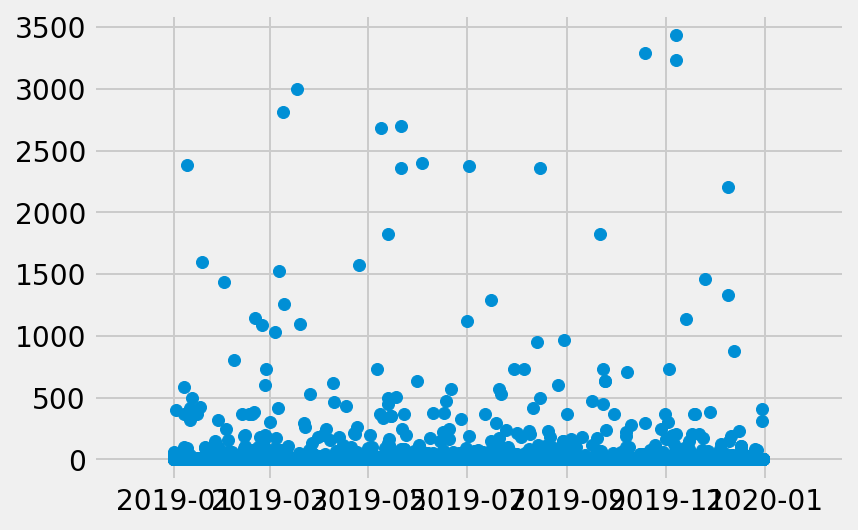

In [118]:
plt.scatter(dv[dv["year"]==2019]["date_rptd"], dv[dv["year"]==2019]["timespan"])

[(0, 4000)]

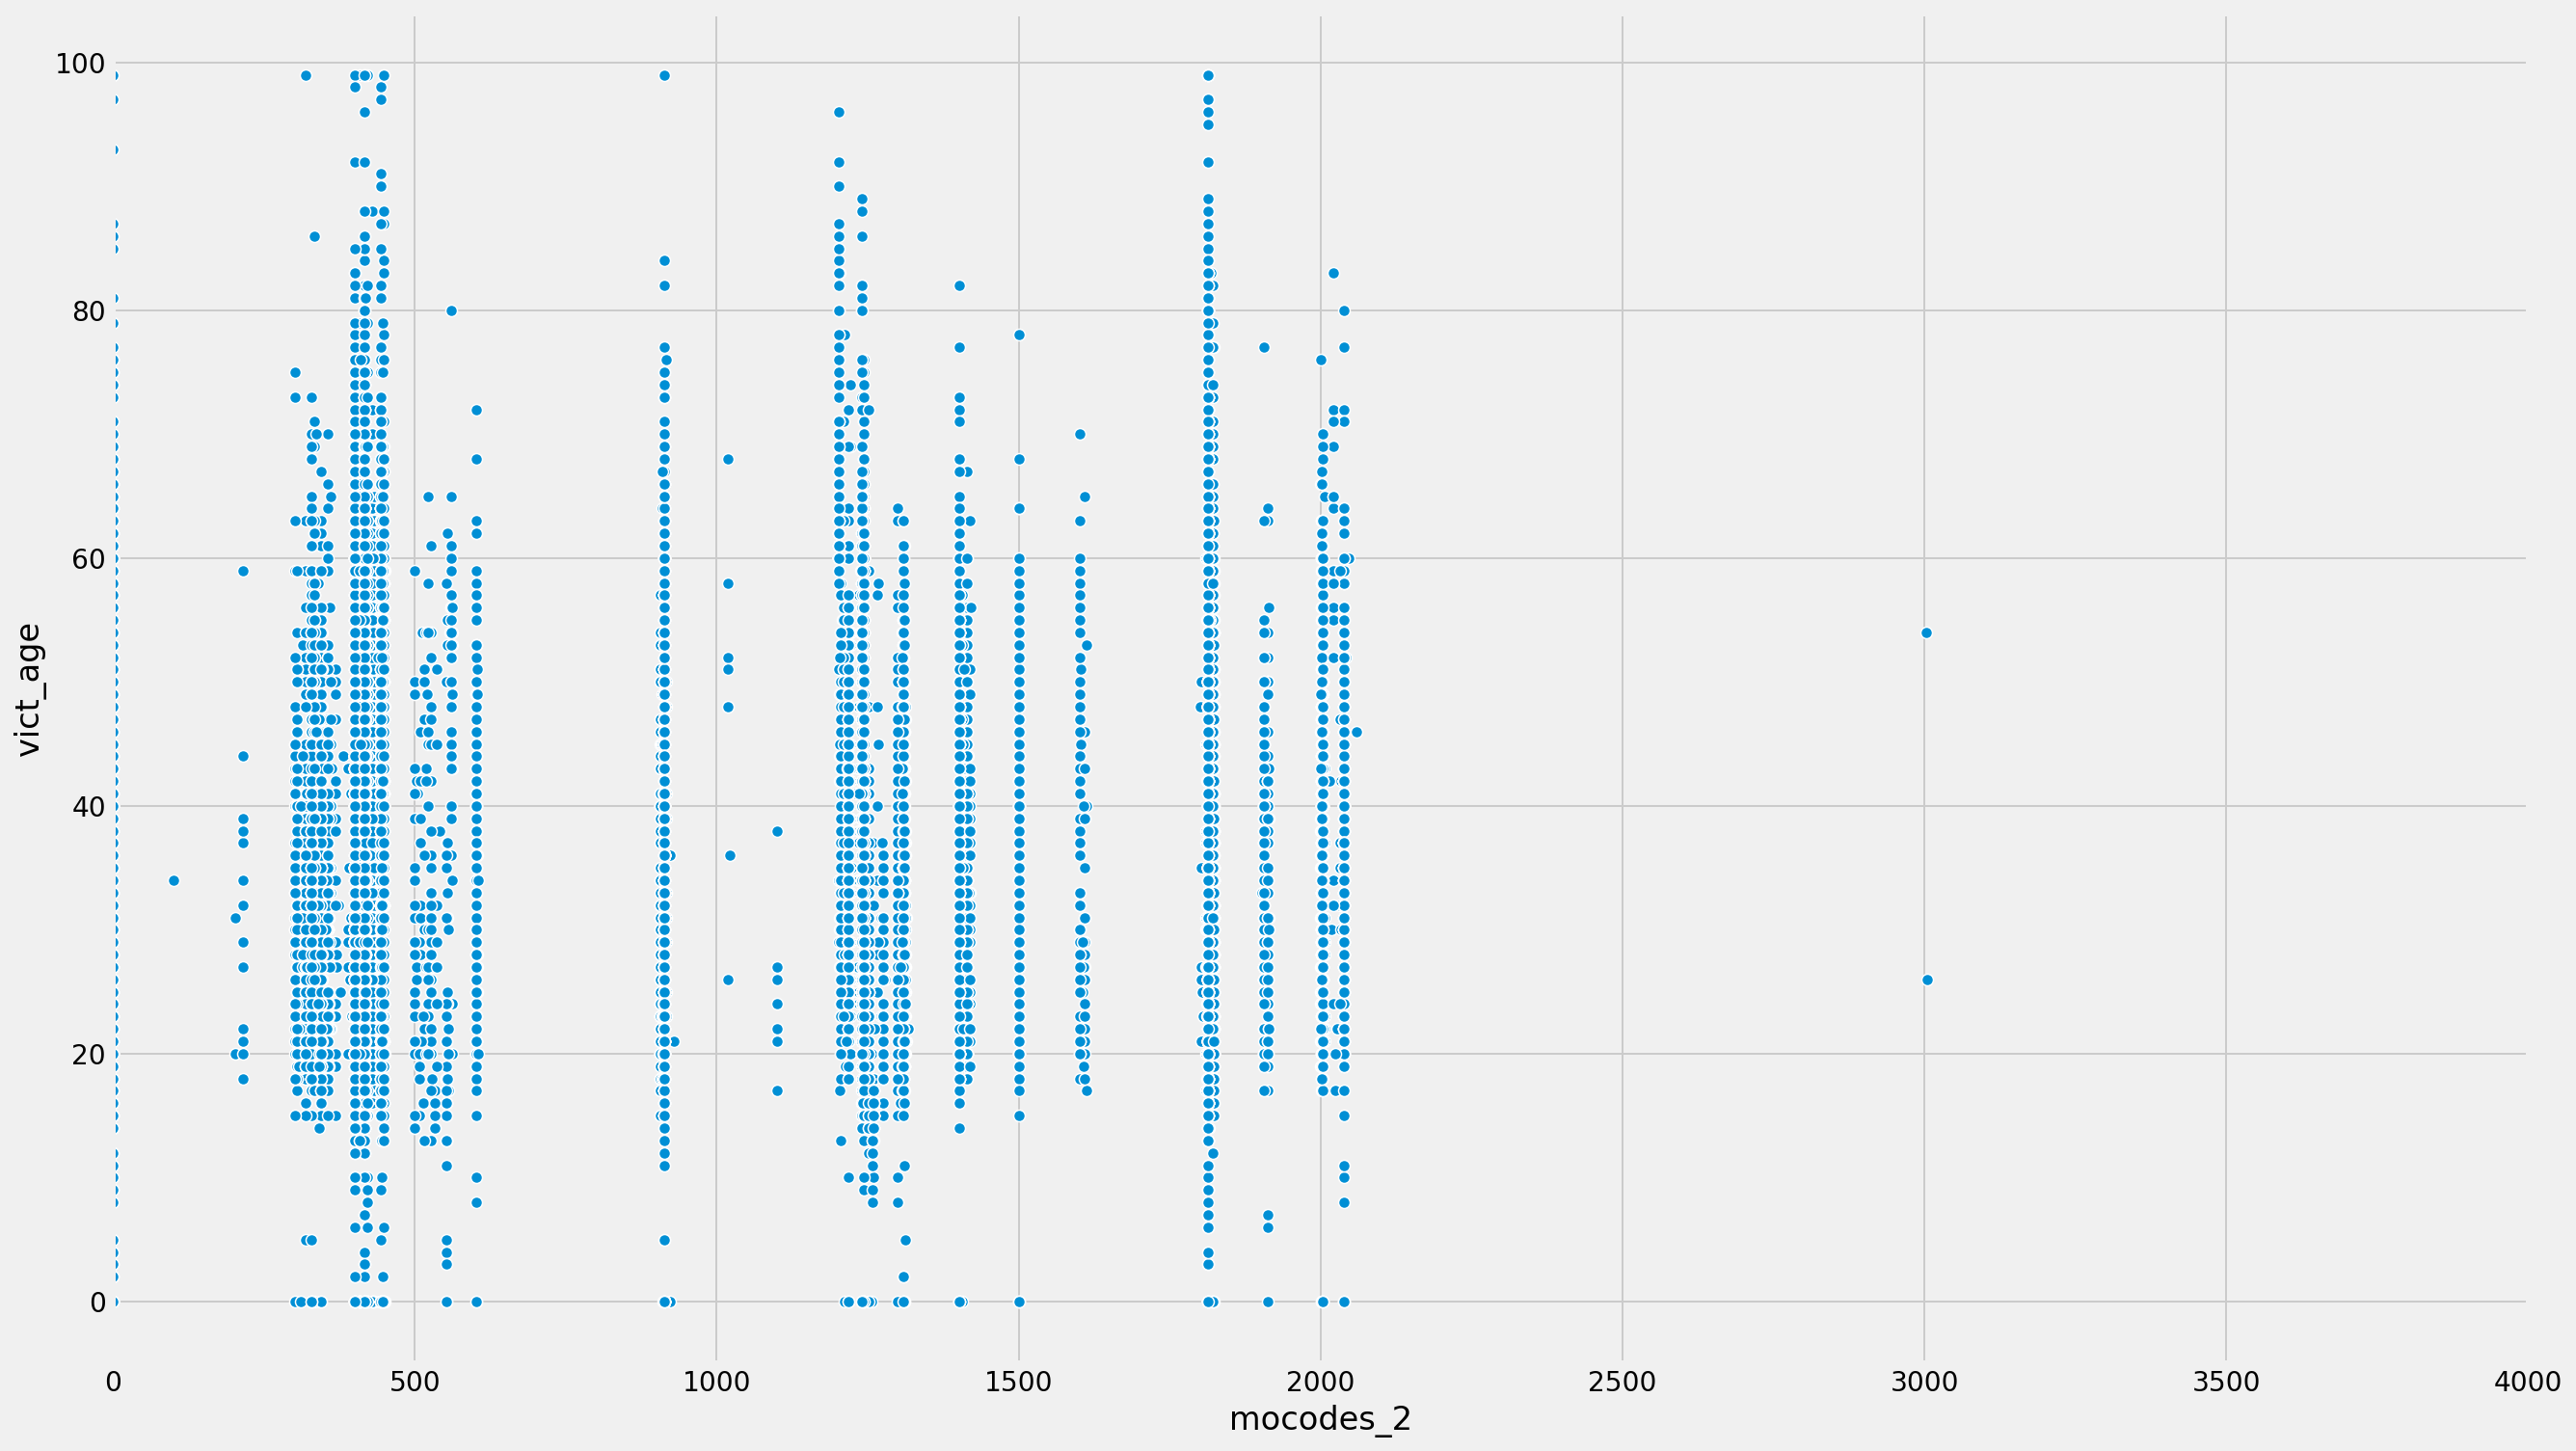

In [122]:
plt.figure(figsize=(20,12))
sns.scatterplot(x="mocodes_2", y="vict_age", data = dv).set(xlim=(0,4000))